<a href="https://colab.research.google.com/github/LaonMoon/Natural-Language-Generation/blob/master/kogpt2_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 환경구성

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 30.4 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 189 kB 34.4 MB/s 
     |████████████████████████████████| 1.2 MB 42.6 MB/s 
     |████████████████████████████████| 48 kB 5.0 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 296 kB/s 
     |████████████████████████████████| 558 kB 45.8 MB/s 
     |████████████████████████████████| 130 kB 46.0 MB/s 
Mounted at /content/gdrive


In [3]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

1.10.0+cu111
4.16.2
2.5.3


#### 데이터 준비

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [5]:
import re

with open("/gdrive/My Drive/novelgen/rofan/rofantotal.TXT") as f:
    lines = f.read()

#lines = lines1+lines2
print(type(lines))
lines=" ".join(lines.split())

lines=re.sub('\(계속\).*?[●○]', '', lines)
lines=re.sub('[●○]', '', lines)
print("len(lines):", len(lines))

<class 'str'>
len(lines): 399624


In [6]:
#download model and tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

Downloading:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:807: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

In [7]:
#test tokenizer
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))

#test model ouput
text = """그는 바라보았다. 나는 """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']
그는 바라보았다. 나는 뭔가 이상하다는 생각이 들었다.
그것은 내가 그걸 어떻게 알았는지 궁금했다.
나는 그것을 알고 있었다.
"이제부터 내일 아침까지 이 모든 것을 다 이야기할게요."
내가 말했다.
그는 나를 쳐다보았다.
그리고는 다시 한 번 내게 물었다.
그러자 그가 대답했다.
'아니, 아무것도 아니야.'
그의 대답은 간단명료하게 들렸다.
하지만 그것은 사실이었다.
내게는, 그리고 그의 말대로라면 나의 머릿속에는 이미 '이상한 생각'이 들어 있었던 것이다.
그러나 그것이 실제로 일어났다는 것은 아니었다.
왜냐하면 지금까지는 그런 생각을 하지 않았기 때문이다.
그래서 우리는 서로에게 말을 걸었다.



In [8]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x) #takes too many time...
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

In [15]:
#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

# 잘 실행되던 코드에서 cuda out memory가 떴고, 이를 해결하기 위해 batch, seq_len을 8,512에서 4,256로 수정했다.
batch,seq_len = 4,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

epoch,train_loss,valid_loss,perplexity,time
0,4.337759,4.027376,56.113461,02:48
1,4.185675,4.114421,61.216751,02:48
2,4.084797,4.183757,65.611885,02:48
3,4.013896,4.227768,68.564026,02:48
4,3.976906,4.235037,69.064255,02:48


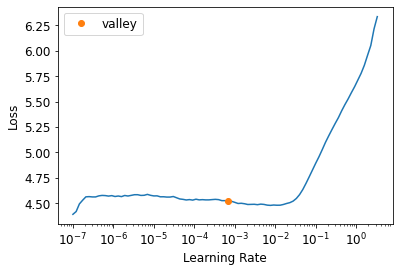

In [16]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]
        
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
learn.fit_one_cycle(5, lr)

In [21]:
prompt="""나는 그를 바라보았다. 그는 나에게 """
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'나는 그를 바라보았다. 그는 나에게 뭔가 물어왔다.“이제부터 내가 할 일이 있습니다.” “네, 네.” “그럼요. 제가 하는 일은?” “아니요, 그럼 내일쯤이면 될 것 같습니다. 그리고 그 다음엔 저를 도와 드릴게요.” “이건 뭐예요?” 아인은 고개를 끄덕이며 대답했다.아인이 말을 끝내자 그녀는 다시 한 번 말문을 열었다."그렇다면 제 일을 하겠습니다!” 그녀가 입을 열었다.\n그리고 있는 그대로의適用的<unk>力. 이 일에 대한 나의 역할은?는 이미 알고 있었다. 하지만 아직은 알 수 없는 것이 있었다.\n生活動。(歷)'